In [31]:
import Statistics
import CUDA
import Images
import SparseArrays
import HDF5
import VideoIO
import Colors
CUDA.allowscalar(false)
include("initROIs.jl")
include("fastHALS.jl")

rawTraces (generic function with 1 method)

In [9]:
video = HDF5.h5open("../data/20211016_163921_animal1learnday1.nwb", "r") do fid
    HDF5.read(fid["analysis/recording_20211016_163921-PP-BP-MC/data"])
end;

In [18]:
diff([extrema(video)...])

1-element Vector{Int16}:
 217

In [28]:
bl = minimum(video)
frames = map(i->UInt8.(video[1:end,2:end,i] .- bl), 1:500);

In [29]:
VideoIO.save("example_raw_video.mp4", frames)

In [39]:
Colors.RGB{Colors.N0f8}(1.0, 0.0, 0.0) + 0.6*Colors.RGB{Colors.N0f8}(0.0, 1.0, 0.0)

In [62]:
import LinearAlgebra

In [111]:
dummy_video = [zeros(Colors.RGB{Colors.N0f8}, 300, 300) for _=1:2000]
masks = Matrix{Colors.RGB{Colors.N0f8}}[]
signals = Vector{Float64}[]
for cell=1:15
    T = length(dummy_video)
    gamma = 0.95
    sigma = 10*1.0#0.2
    fake_s = 10 .* (randn(T).^2) .* (rand(T) .> 0.97)
    fake_c = similar(fake_s)
    fake_c[1] = fake_s[1]
    for i=2:T
        fake_c[i] = gamma*fake_c[i-1] + fake_s[i]
    end
    fake_c ./= maximum(fake_c)
    c = 300*rand(2)
    sigma = 15+15*rand()
    cov = -200 + 400*rand()
    sigInv = inv([sigma^2 cov; cov sigma^2])
    col_vec = rand(3)
    col_vec ./= 0.5*sum(col_vec)
    clamp!(col_vec, 0.0, 1.0)
    col = Colors.RGB{Colors.N0f8}(col_vec...)
    mask = [exp(-0.5*(([x,y]-c)'*sigInv*([x,y]-c))) for x=1:300, y=1:300]
    push!(signals, fake_c)
    push!(masks, col*mask)
    for t=1:T
        dummy_video[t] .= col.*mask.*fake_c[t] .+ (1 .- fake_c[t].*mask) .* dummy_video[t]
    end
end

15-element Vector{Matrix{ColorTypes.RGB{FixedPointNumbers.N0f8}}}:
 [RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); … ; RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0)]
 [RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); … ; RGB{N0f8}(0.0,0.004,0.0) RGB{N0f8}(0.0,0.004,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.004,0.0) RGB{N0f8}(0.0,0.004,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0)]
 [RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); … ; RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0)]
 [RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); … ; RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0)]
 [RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); … ; RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0)]
 [RGB{N0f8}(0.22,0.282,0.035) RGB{N0f8}(0.224,0.286,0.035) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.239,0.306,0.039) RGB{N0f8}(0.243,0.31,0.039) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); … ; RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0)]
 [RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); … ; RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0)]
 [RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); … ; RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0)]
 [RGB{N0f8}(0.145,0.016,0.114) RGB{N0f8}(0.153,0.016,0.122) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.145,0.016,0.114) RGB{N0f8}(0.157,0.016,0.122) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); … ; RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0)]
 [RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); … ; RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0)]
 [RGB{N0f8}(0.0,0.0
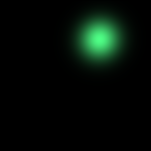
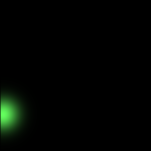
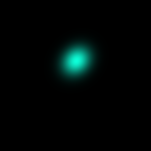
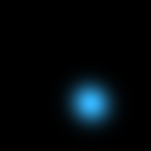
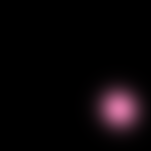
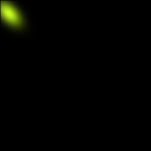
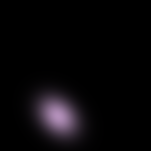
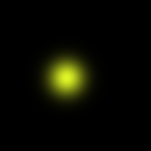
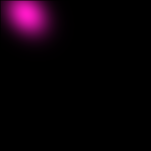
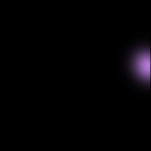
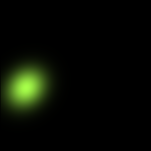
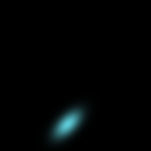
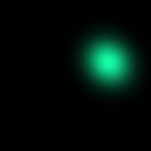
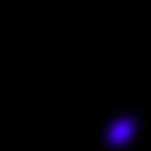
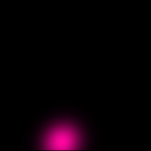

In [112]:
masks

In [113]:
VideoIO.save("example_dummy_color_video.mp4", dummy_video)

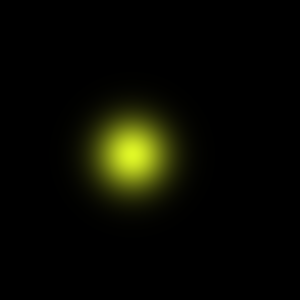

In [117]:
masks[8]

In [118]:
import Plots

In [127]:
Base.isless(a::Colors.RGB{Colors.N0f8}, b::Colors.RGB{Colors.N0f8}) = abs(a) < abs(b)

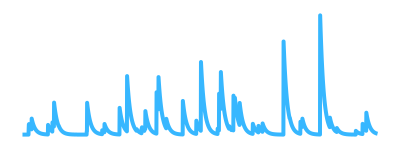

In [146]:
Plots.plot(signals[4], c=maximum(masks[4]), grid=false, axis=false,
           ticks=false, legend=false, lw=4, size=(400, 150), format=:png)

In [149]:
using Plots

In [299]:
T = 25000
gamma = 0.9
sigma = 4.0#0.2
fake_s = 10 .* (randn(T).^2) .* (rand(T) .> 0.985)
fake_c = similar(fake_s)
fake_c[1] = fake_s[1]
for i=2:T
    fake_c[i] = gamma*fake_c[i-1] + fake_s[i]
end
fake_y = fake_c + sigma*randn(T);
#plot(p_fake_s, p_fake_c, p_fake_y, layout=(3, 1), legend=false, yticks=[],
#     ylim=(-50, 300), xlim=(20*60*6.9, 20*60*7.6), size=(300, 500))

In [147]:
struct Pool
    v::Float64
    w::Float64
    t::Int64
    l::Int64
end

function oasis(y, gamma, lambda)
    T = length(y)
    pools = Pool[]
    i = 0
    for t=1:T
        yt = y[t]
        v = yt - lambda*(1 - gamma + (t==T)*gamma)
        push!(pools, Pool(v,1,t,1))
        while i>0 && pools[i+1].v < (gamma^pools[i].l) * pools[i].v
            v = pools[i].w*pools[i].v
            v += gamma^pools[i].l*pools[i+1].w*pools[i+1].v
            v /= pools[i].w + gamma^(2*pools[i].l)*pools[i+1].w
            w = pools[i].w + gamma^(2*pools[i].l) + pools[i+1].w
            pools[i] = Pool(v, w, pools[i].t, pools[i].l + pools[i+1].l)
            pop!(pools)
            i -= 1
        end
        i += 1
    end
    s = zero(y)
    c = zero(y)
    for pool in pools
        for t=0:pool.l-1
            c[pool.t + t] = gamma^t*max(0, pool.v)
        end
        if pool.t > 1
            s[pool.t] = c[pool.t] - gamma*c[pool.t-1]
        end
    end
    return c, s
end

oasis (generic function with 1 method)

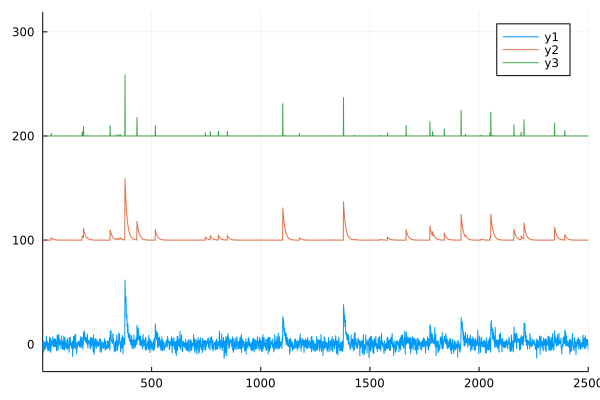

In [300]:
plot(fake_y, xlim=(1, 2500))
plot!(fake_c .+ 100)
plot!(fake_s .+ 200)

┌ Info: Saved animation to 
│   fn = /home/emil/arrowmaze_project/julia_ca_processing/lab_meeting_viz/lambda_anim.gif
└ @ Plots /home/emil/.julia/packages/Plots/4oFWe/src/animation.jl:114


Plots.AnimatedGif("/home/emil/arrowmaze_project/julia_ca_processing/lab_meeting_viz/lambda_anim.gif")
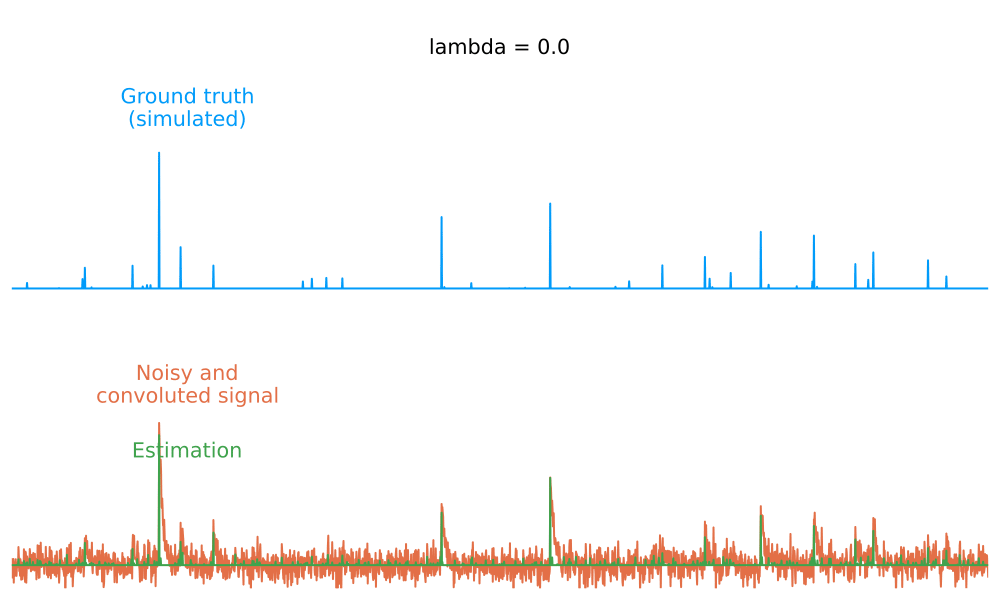

In [320]:
anim = @animate for lam ∈ (0:0.1:20).^2
    est_c, est_s = oasis(fake_y, gamma, lam)
    p = plot(fake_s .+ 120, lw=2)
    plot!(fake_y, lw=2)
    plot!(est_s, xlim=(1,2500), ylim=(-10, 240), legend=false, lw=2,
          grid=false, xticks=[], yticks=[], axis=:false, size=(1000, 600))
    annotate!(450, 200, "Ground truth\n(simulated)", palette(:default)[1])
    annotate!(450, 80, "Noisy and\nconvoluted signal", palette(:default)[2])
    annotate!(450, 50, "Estimation", palette(:default)[3])
    annotate!(1250, 225, "lambda = $(round(lam*100)/100)")
end
gif(anim, "lab_meeting_viz/lambda_anim.gif", fps = 15)

In [255]:
using Statistics

In [389]:
function kurtosis(x)
    N = length(x)
    x_m = sum(x) / N
    return sum((x .- x_m).^4) ./ N ./ ((sum((x .- x_m).^2)./N).^2)
end

function negentropy_est(x)
    N = length(x)
    x_m = sum(x) / N
    sd = sqrt((sum((x .- x_m).^2)./N))
    return (sum(((x .- x_m)./sd).^3) ./ N)^2/12 + (kurtosis(x)-3)^2/48
end

negentropy_est (generic function with 1 method)

In [390]:
function sweep_lambda(y, c, s, lambdas, gamma)
    res = Float64[]
    err = Float64[]
    kur = Float64[]
    c_cor = Float64[]
    s_cor = Float64[]
    negentropy = Float64[]
    for lambda in lambdas
        c_est, s_est = oasis(y, gamma, lambda)
        push!(res, sum((c_est .- y).^2))
        push!(err, sum((c_est .- c).^2))
        push!(kur, kurtosis(c_est .- y))
        push!(negentropy, negentropy_est(c_est .- y))
        push!(c_cor, Statistics.cor(c_est, c))
        push!(s_cor, Statistics.cor(s_est, s))
    end
    return res, err, c_cor, s_cor, kur, negentropy
end

sweep_lambda (generic function with 1 method)

In [391]:
@time est_c, est_s = oasis(fake_y, gamma, lam);

  0.005865 seconds (19 allocations: 647.391 KiB)


In [392]:
@time res, err, c_cor, s_cor, kur, negentropy = sweep_lambda(fake_y, fake_c, fake_s, 0:400, 0.9);

  5.358899 seconds (806.70 k allocations: 971.301 MiB, 3.09% gc time, 8.38% compilation time)


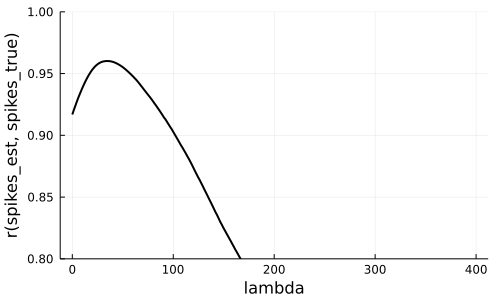

In [393]:
plot(0:400, s_cor, ylim=(0.8, 1.00), legend=false, size=(500, 300),
     xlabel="lambda", ylabel="r(spikes_est, spikes_true)", lw=2, color=:black)

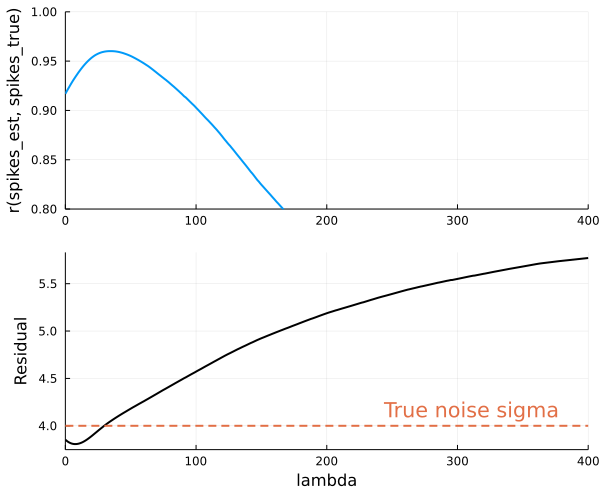

In [387]:
p1 = plot(0.0:1:400, sqrt.(res/T), color=:black, legend=false, ylabel="Residual")
plot!(p1, [0, 400], [4.0, 4.0], ls=:dash, xlabel="lambda")
annotate!(310, 4.17, "True noise sigma", palette(:default)[2])
p2 = plot(0:400, s_cor, ylim=(0.8, 1.00), legend=false,
          ylabel="r(spikes_est, spikes_true)")
plot(p2, p1, layout=(2,1), size=(600, 500), lw=2, color=:black, xlim=(0,400))

In [334]:
import DSP

In [335]:
P = DSP.welch_pgram(fake_y)
f = DSP.freq(P)
p = DSP.power(P)
sqrt(Statistics.mean(p[f .> 0.25]) / 2)

4.162229303616044

In [337]:
sqrt(Statistics.mean(p[f .> 0.1]) / 2)

4.27766764439094

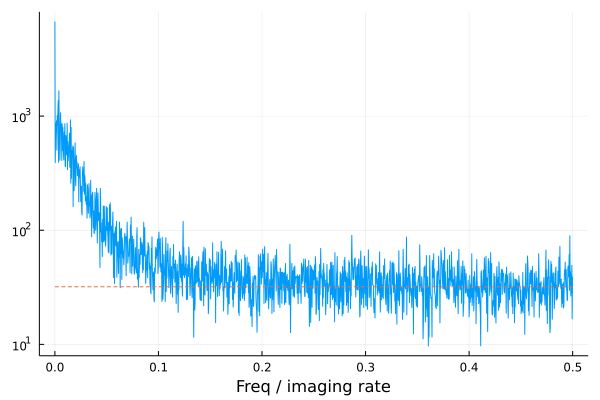

In [350]:
plot(f, p, yaxis=:log, legend=false)
plot!([0, 0.5], 2*[4.0, 4.0].^2, ls=:dash, xlabel="Freq / imaging rate")
annotate!(310, 4.17, "True noise sigma", palette(:default)[2])

In [376]:
T = 25000
gamma = 0.9
sigma = 1.0#0.2
fake_s_new = 10 .* (randn(T).^2) .* (rand(T) .> 0.985)
fake_c_new = similar(fake_s_new)
fake_c_new[1] = fake_s_new[1]
for i=2:T
    fake_c_new[i] = gamma*fake_c_new[i-1] + fake_s_new[i]
end
fake_y_new = fake_c_new + sigma*randn(T);

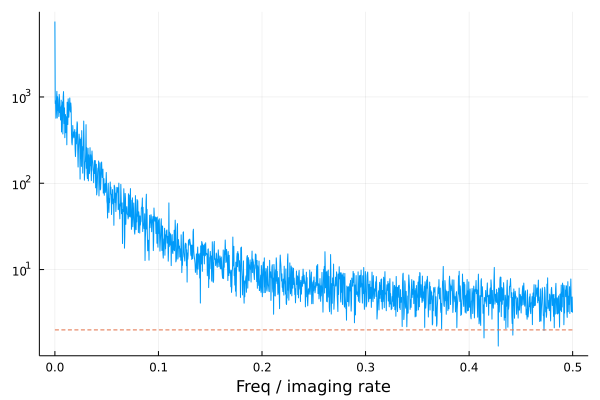

In [377]:
P = DSP.welch_pgram(fake_y_new)
f = DSP.freq(P)
p = DSP.power(P)
plot(f, p, yaxis=:log, legend=false)
plot!([0, 0.5], 2*[sigma, sigma].^2, ls=:dash, xlabel="Freq / imaging rate")
annotate!(310, 4.17, "True noise sigma", palette(:default)[2])

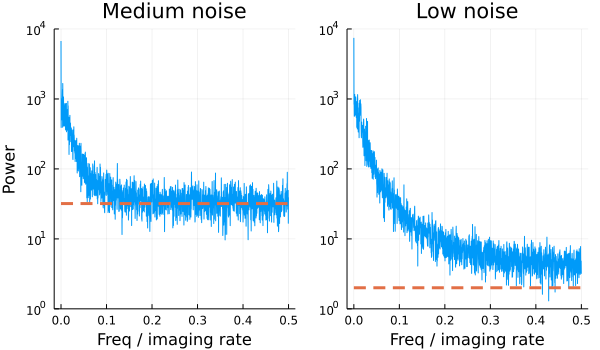

In [386]:
P = DSP.welch_pgram(fake_y)
f = DSP.freq(P)
p = DSP.power(P)
p1 = plot(f, p, yaxis=:log, legend=false, title="Medium noise")
plot!([0, 0.5], 2*[4.0, 4.0].^2, ls=:dash, xlabel="Freq / imaging rate", ylabel="Power", lw=3)
annotate!(310, 4.17, "True noise sigma", palette(:default)[2])
P = DSP.welch_pgram(fake_y_new)
f = DSP.freq(P)
p = DSP.power(P)
p2 = plot(f, p, yaxis=:log, legend=false, title="Low noise")
plot!([0, 0.5], 2*[1.0, 1.0].^2, ls=:dash, xlabel="Freq / imaging rate", lw=3)
annotate!(310, 4.17, "True noise sigma", palette(:default)[2])
plot(p1, p2, layout=(1,2), ylim=(1, 10000), size=(600, 350))

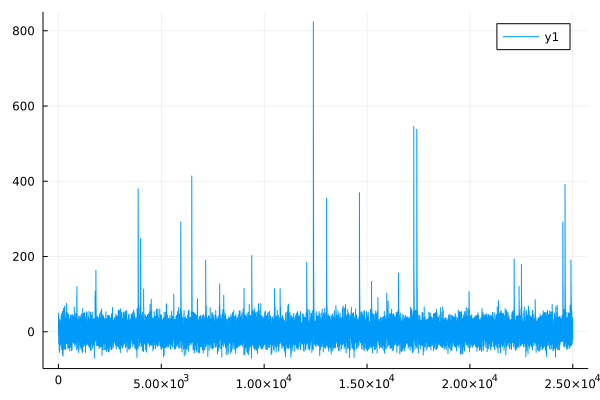

In [369]:
plot(fake_y_new)

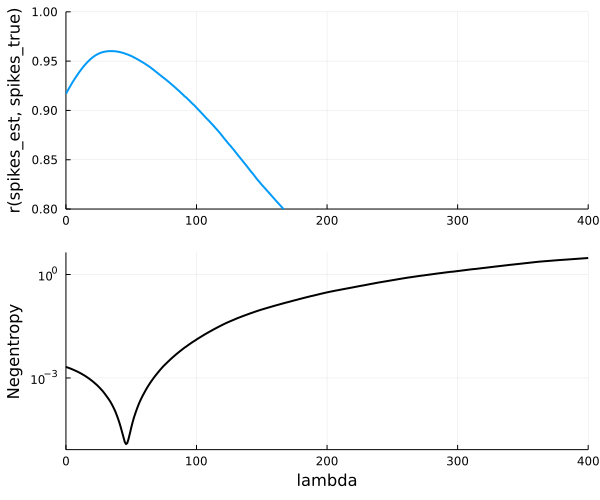

In [401]:
p1 = plot(0.0:400, negentropy, color=:black, legend=false, ylabel="Negentropy", yaxis=:log, xlabel="lambda")
p2 = plot(0:400, s_cor, ylim=(0.8, 1.00), legend=false,
          ylabel="r(spikes_est, spikes_true)")
plot(p2, p1, layout=(2,1), size=(600, 500), lw=2, color=:black, xlim=(0,400))

In [403]:
using ProgressMeter

In [404]:
function joint_opt(y, lambdas, gammas, c_true, s_true)
    negent = zeros(length(lambdas), length(gammas))
    c_cor = zeros(length(lambdas), length(gammas))
    s_cor = zeros(length(lambdas), length(gammas))
    @showprogress "Running OASIS" for i=1:length(lambdas)
        for j=1:length(gammas)
            lambda = lambdas[i]
            gamma = gammas[j]
            c_est, s_est = oasis(y, gamma, lambda)
            negent[i, j] = negentropy_est(c_est .- y)
            c_cor[i, j] = Statistics.cor(c_est, c_true)
            s_cor[i, j] = Statistics.cor(s_est, s_true)
        end
    end
    return negent, c_cor, s_cor
end

joint_opt (generic function with 1 method)

Running OASIS100%|██████████████████████████████████████| Time: 0:02:15


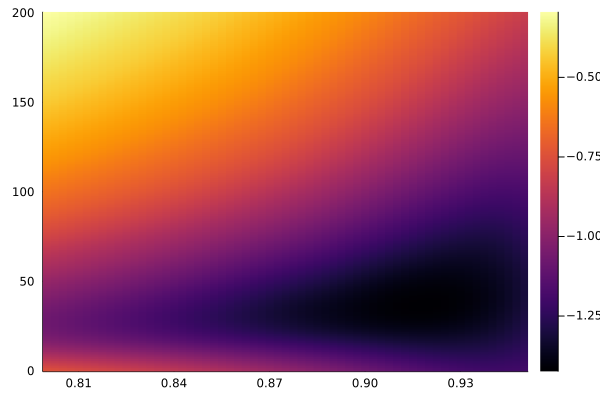

In [405]:
lambdas = 0:200
gammas = 0.8:0.0025:0.95
negent, c_cor, s_cor = joint_opt(fake_y, lambdas, gammas, fake_c, fake_s);
heatmap(gammas, lambdas, log10.(negent))
heatmap(gammas, lambdas, log10.(1.0 .- c_cor))
heatmap(gammas, lambdas, log10.(1.0 .- s_cor))

$$\gamma = \exp(\frac{\Delta t}{\tau})$$
$$\exp(\tau_2/\tau) = 1/2$$

$$ \tau=\frac{\Delta t}{\ln \gamma}$$

$$\tau = \frac{\tau_2}{\ln\frac{1}{2}}$$
$$\frac{\tau_2}{\ln\frac{1}{2}}= \frac{\Delta t}{\ln \gamma}$$
$$\tau_2= \frac{\Delta t\ln\frac{1}{2}}{\ln \gamma}$$

In [414]:
halftime(gamma) = 1*log(0.5)/log(gamma)

halftime (generic function with 1 method)

(8.050237544005073, 36)

In [453]:
m_pos

CartesianIndex(37, 48)

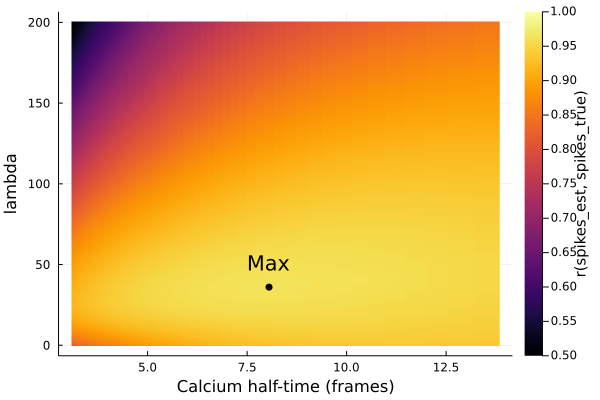

In [465]:
h1 = heatmap(halftime.(gammas), lambdas, s_cor, clim=(0.5, 1.0),
        colorbar_title="r(spikes_est, spikes_true)",
        xlabel="Calcium half-time (frames)",
        ylabel="lambda")
m, m_pos = findmax(s_cor)
scatter!([halftime(gammas[m_pos[2]])], [lambdas[m_pos[1]]],
         legend=false, color=:black)
annotate!(halftime(gammas[m_pos[2]]), lambdas[m_pos[1]]+15, "Max")

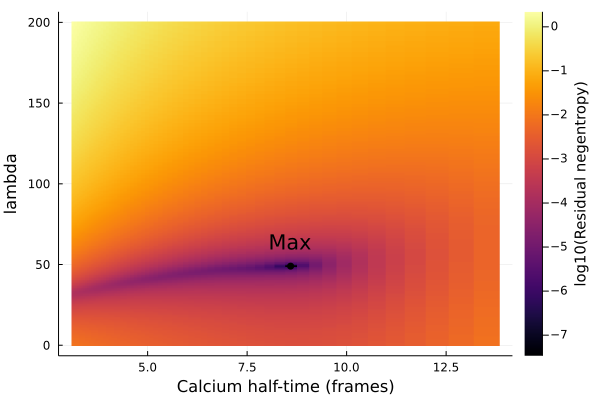

In [466]:
h2 = heatmap(halftime.(gammas), lambdas, log10.(negent),
        colorbar_title="log10(Residual negentropy)",
        xlabel="Calcium half-time (frames)",
        ylabel="lambda")
m, m_pos = findmax(-negent)
scatter!([halftime(gammas[m_pos[2]])], [lambdas[m_pos[1]]],
         legend=false, color=:black)
annotate!(halftime(gammas[m_pos[2]]), lambdas[m_pos[1]]+15, "Max")

In [444]:
using Measures

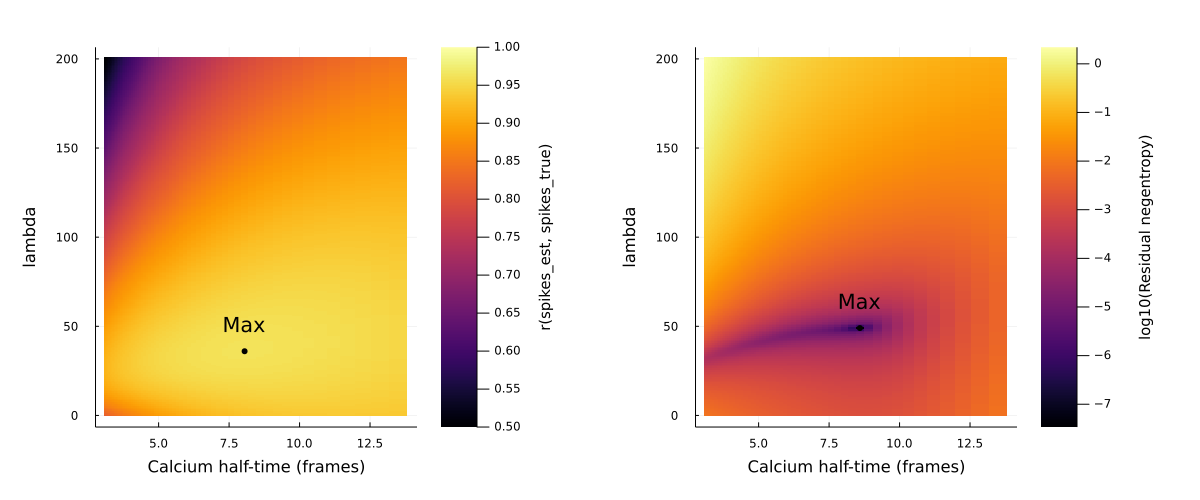

In [467]:
plot(h1, h2, size=(1200, 500), margin=10mm, fmt=:png)

6.578813478960585

In [469]:
60*22 / 100

13.2

In [471]:
import HDF5
real_c = HDF5.h5open("example_traces.h5", "r") do fid
    HDF5.read(fid, "just_init")
end
ex_c = real_c[:,32]

24186-element Vector{Float32}:
  39.524006
  21.348957
  47.4388
  25.481281
   4.4400215
  17.875813
  11.887775
  10.370686
  44.976643
  15.151203
  63.713215
  19.155354
  36.51253
   ⋮
  12.292072
  -8.660809
 -24.997478
 -22.947186
 -29.75578
 -21.876385
 -12.473553
  -4.3607597
  -5.010418
  -3.0538752
  11.359455
   4.114094

┌ Info: Saved animation to 
│   fn = /home/emil/arrowmaze_project/julia_ca_processing/lab_meeting_viz/lambda_anim_real_data.gif
└ @ Plots /home/emil/.julia/packages/Plots/4oFWe/src/animation.jl:114


Plots.AnimatedGif("/home/emil/arrowmaze_project/julia_ca_processing/lab_meeting_viz/lambda_anim_real_data.gif")
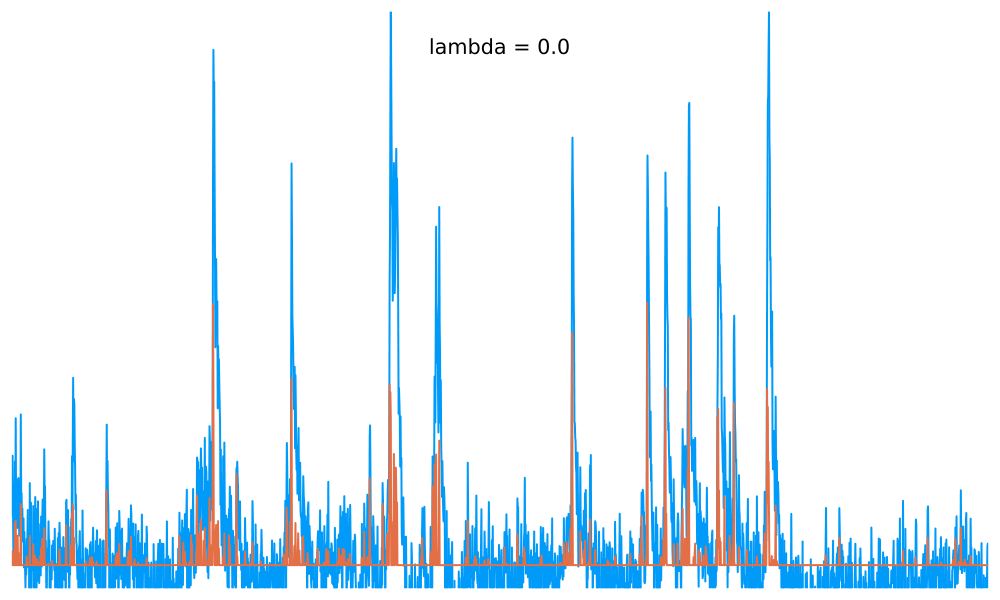

In [476]:
anim = @animate for lam ∈ (0:0.1:20).^2
    est_c, est_s = oasis(ex_c, 0.88, lam)
    plot(ex_c, lw=2)
    plot!(est_s, xlim=(1,2500), ylim=(-10, 240), legend=false, lw=2,
          grid=false, xticks=[], yticks=[], axis=:false, size=(1000, 600))
    #annotate!(450, 200, "Ground truth\n(simulated)", palette(:default)[1])
    #annotate!(450, 80, "Noisy and\nconvoluted signal", palette(:default)[2])
    #annotate!(450, 50, "Estimation", palette(:default)[3])
    annotate!(1250, 225, "lambda = $(round(lam*100)/100)")
end
gif(anim, "lab_meeting_viz/lambda_anim_real_data.gif", fps = 15)

In [478]:
negentropy = Float64[]
for lambda in lambdas
    c_est, s_est = oasis(ex_c, gamma, lambda)
    push!(negentropy, negentropy_est(c_est .- ex_c))
end

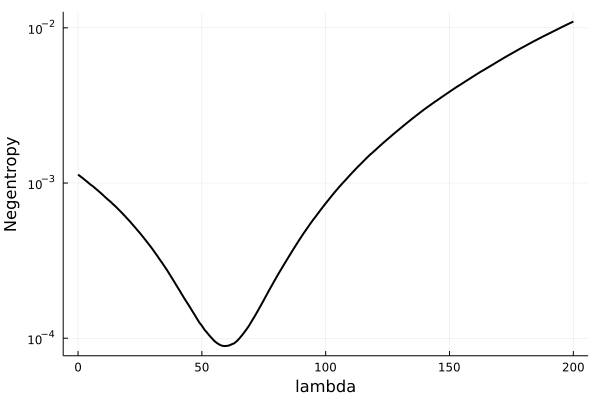

In [482]:
p1 = plot(lambdas, negentropy, color=:black, legend=false,
          ylabel="Negentropy", yaxis=:log, xlabel="lambda", lw=2)

In [480]:
p1 = plot(0.0:400, negentropy, color=:black, legend=false, ylabel="Negentropy", yaxis=:log, xlabel="lambda")

BoundsError: BoundsError: attempt to access 201-element Vector{Float64} at index [1:401]

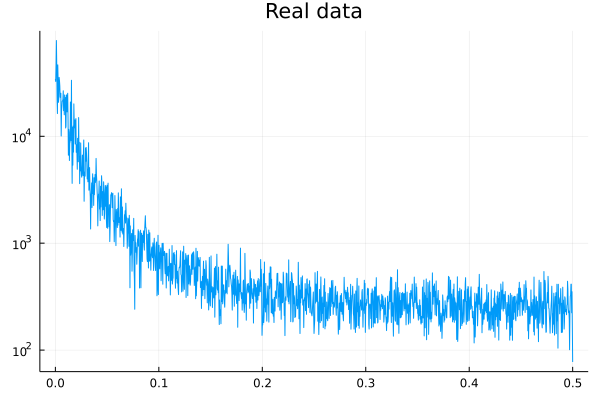

In [483]:
P = DSP.welch_pgram(ex_c)
f = DSP.freq(P)
p = DSP.power(P)
p1 = plot(f, p, yaxis=:log, legend=false, title="Real data")

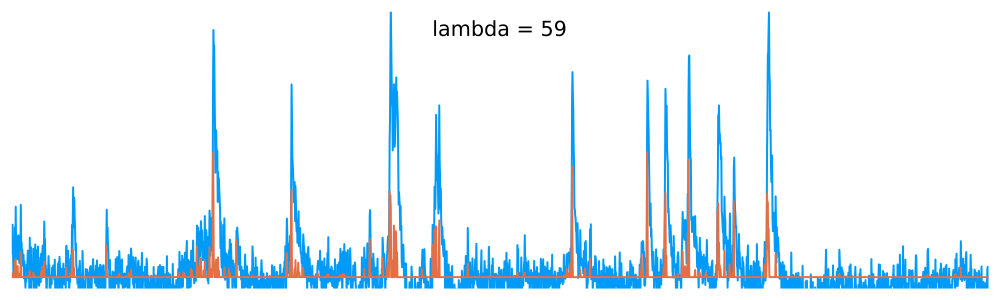

In [490]:
lam = 59
est_c, est_s = oasis(ex_c, 0.88, lam)
plot(ex_c, lw=2)
plot!(est_s, xlim=(1,2500), ylim=(-10, 240), legend=false, lw=2,
      grid=false, xticks=[], yticks=[], axis=:false, size=(1000, 300))
#annotate!(450, 200, "Ground truth\n(simulated)", palette(:default)[1])
#annotate!(450, 80, "Noisy and\nconvoluted signal", palette(:default)[2])
#annotate!(450, 50, "Estimation", palette(:default)[3])
annotate!(1250, 225, "lambda = $lam")

In [486]:
findmin(negentropy)

(8.902916306396946e-5, 60)

In [488]:
lambdas[20]

19

In [491]:
2500 / 20

125.0